In [1]:
## fine tuning sam2

In [1]:
from mb_annotation.segsam2 import load_data,sam_predictor,train_model

/home/winnow/.local/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [2]:
data = load_data("/home/winnow/Desktop/data_to_test/final_food_data.csv")
data[0]

{'image': '/home/winnow/Desktop/data_to_test/images/0000.png',
 'annotation': '/home/winnow/Desktop/data_to_test/mask/0000_mask.png'}

In [52]:
predictor = sam_predictor('/home/winnow/segment-anything-2/checkpoints/sam2_hiera_small.pt','./sam2_hiera_s.yaml',device='cpu')

In [4]:
new_predictor = train_model(data, predictor, epochs=5, lr=1e-6,device='cpu',save_step=5)

step:0 loss:2.6383 seg_loss:2.5943 score_loss:0.8800 mean_iou:0.0008
step:1 loss:0.2170 seg_loss:0.2127 score_loss:0.0862 mean_iou:0.0023
step:2 loss:1.0615 seg_loss:1.0489 score_loss:0.2511 mean_iou:0.0026
step:3 loss:1.5372 seg_loss:1.5312 score_loss:0.1194 mean_iou:0.0030
step:4 loss:3.5168 seg_loss:3.5048 score_loss:0.2409 mean_iou:0.0031


In [ ]:
import torch

sam2_checkpoint = "/home/winnow/segment-anything-2/checkpoints/sam2_hiera_small.pt"
model_cfg = "./sam2_hiera_s.yaml" # "sam2_hiera_l.yaml"

predictor = sam_predictor( sam2_checkpoint, model_cfg,device="cuda")
predictor.model.load_state_dict(torch.load("./sam_model_checkpoints/sam_model.pt"))

In [5]:
import cv2
import numpy as np
def read_image(image_path, mask_path): # read and resize image and mask
        img = cv2.imread(image_path)[...,::-1]  # read image
        mask = cv2.imread(mask_path,0)
        r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
        img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
        mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)),interpolation=cv2.INTER_NEAREST)
        return img, mask


def get_points(mask,num_points): # Sample points inside the input mask
        points=[]
        for i in range(num_points):
            coords = np.argwhere(mask > 0)
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([[yx[1], yx[0]]])
        return np.array(points)

In [22]:
import pandas as pd

t1 = pd.read_csv("/home/winnow/Desktop/data_to_test/final_food_data.csv")
t1.head(2)

,Unnamed: 0.1,Unnamed: 0,labels,bbox,image_path,mask_path,food_bbox,old_mask_path,old_image_path,tray_bbox
0,0,0,['Pumpkin seed rolls'],"['[827, 196, 1282, 1007]']",/home/winnow/Desktop/data_to_test/images/0000.png,/home/winnow/Desktop/data_to_test/mask/0000_ma...,"[827, 196, 1282, 1007]",0000_mask.png,0000.png,"[58.0, 0.0, 1142.0, 1496.0]"
1,1,1,['Three-grain rolls'],"['[192, 119, 1055, 976]']",/home/winnow/Desktop/data_to_test/images/0001.png,/home/winnow/Desktop/data_to_test/mask/0001_ma...,"[192, 119, 1055, 976]",0001_mask.png,0001.png,"[0.0, 0.0, 1200.0, 1600.0]"


In [90]:
# # read image and sample points
# image,mask = read_image('/home/winnow/Desktop/data_to_test/images/0007.png','/home/winnow/Desktop/data_to_test/mask/0007_mask.png')
# input_points = get_points(mask,3)
# input_labels = np.ones([len(input_points),1])

value = 155
image = cv2.imread(t1['image_path'].iloc[value])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
bbox = eval((t1['food_bbox'].iloc[value]))
bbox_np = np.array(bbox,dtype=np.float32)
bbox_np

array([ 133.,   29., 1554., 1137.], dtype=float32)

In [72]:
from mb_annotation.segsam2 import *

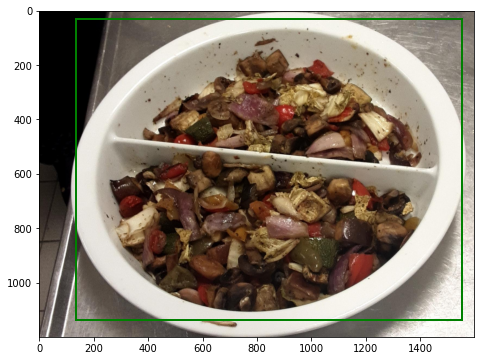

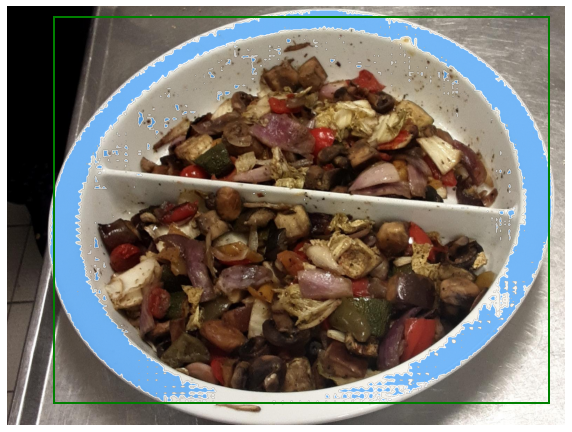

In [91]:
import matplotlib.pyplot as plt
import torch

with torch.no_grad():
        new_predictor.set_image(image)
        masks, scores, logits = new_predictor.predict(
            box=bbox_np,multimask_output=False)
        
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]
        logits = logits[sorted_ind]

        plt.figure(figsize=(9, 6))
        plt.imshow(image)

        if bbox is not None:
            show_box(bbox, plt.gca())

        show_masks_image(image, masks, scores, box_coords=bbox)

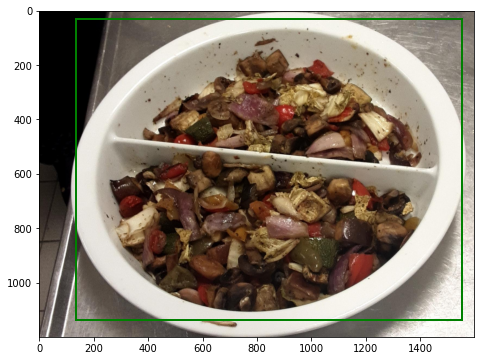

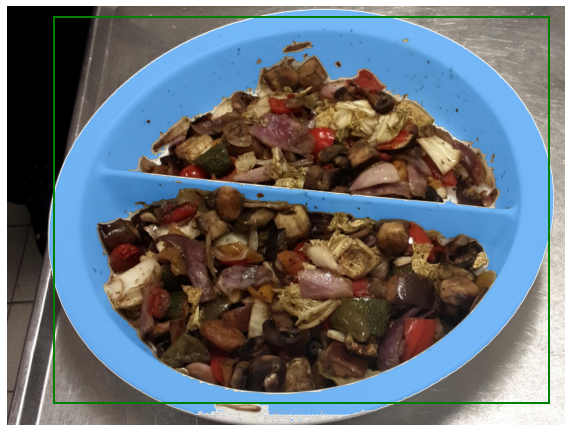

In [92]:

with torch.no_grad():
        predictor.set_image(image)
        masks, scores, logits = predictor.predict(box=bbox, multimask_output=False)
        
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]
        logits = logits[sorted_ind]

        plt.figure(figsize=(9, 6))
        plt.imshow(image)

        if bbox is not None:
            show_box(bbox, plt.gca())

        show_masks_image(image, masks, scores, box_coords=bbox)